In [10]:
from google.oauth2 import service_account
from langchain_google_vertexai import ChatVertexAI

# Đường dẫn đến tệp JSON Key
credentials_path = "E:/LLM_clone/Tdtu-chatbot/credentials/tdtuchat-16614553b756.json"

# Tạo credentials từ tệp JSON Key
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# Khởi tạo mô hình
llm = ChatVertexAI(
    model="gemini-1.5-pro",  # Sử dụng mô hình phù hợp
    temperature=0.6,         # Độ sáng tạo
    max_tokens=200,          # Số token tối đa
    credentials=credentials, # Truyền credentials vào đây
    max_retries=5            # Số lần thử lại khi có lỗi
)

In [11]:
from langchain.tools import tool
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def square(a: int) -> int:
    """Calculates the square of a number."""
    a = int(a)
    return a * a

# setup the toolkit
math_toolkit = [add, multiply, square]

from langchain.tools import tool


@tool
def make_upper_case(text: str) -> str:
    """ convert string to all upper case string"""
    return text.upper()


@tool
def make_lower_case(text: str) -> str:
    """ convert string to all lower case string"""
    return text.lower()

@tool
def add_smiley(text: str) -> str:
    """ add smiley face to the end of string"""
    return text + ' :)'


# setup the toolkit
text_toolkit = [make_upper_case, make_lower_case, add_smiley]

In [12]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate

def create_tool_agent(llm: ChatVertexAI, tools: list, system_prompt: str):
    """Helper function to create agents with custom tools and system prompt
    Args:
        llm (ChatVertexAI): LLM for the agent
        tools (list): list of tools the agent will use
        system_prompt (str): text describing specific agent purpose

    Returns:
        executor (AgentExecutor): Runnable for the agent created.
    """
    
    # Each worker node will be given a name and some tools.
    
    system_prompt_template = PromptTemplate(

                template= system_prompt + """
                ONLY respond to the part of query relevant to your purpose.
                IGNORE tasks you can't complete. 
                Use the following context to answer your query 
                if available: \n {agent_history} \n
                """,
                input_variables=["agent_history"],
            )

    #define system message
    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

    prompt = ChatPromptTemplate.from_messages(
        [system_message_prompt,
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_tool_calling_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, 
                return_intermediate_steps= True, verbose = False)
    return executor

In [13]:
#define system prompt for tool calling agent
system_prompt = """ You are a mathematical assistant.
        Use your tools to answer questions. If you do not have a tool to
        answer the question, say so. """

math_agent = create_tool_agent(llm=llm, tools = math_toolkit, 
              system_prompt = system_prompt)


#define system prompt for tool calling agent
system_prompt = """ You are a text editor assistant.
        Use your tools to complete requests. If you do not have a tool to
       complete the request, say so. """

text_agent = create_tool_agent(llm=llm, tools = text_toolkit, 
                    system_prompt = system_prompt)

In [32]:
from langchain_core.messages import AIMessage
# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
# from pydantic import BaseModel
from langchain_core.output_parsers import JsonOutputParser

system_prompt_template = PromptTemplate(

      template= """ You are a talkative and helpful assistant that summarises agent history 
                      in response to the original user query below. 
                      SUMMARISE ALL THE OUTPUTS AND TOOLS USED in agent_history.
                      The agent history is as follows: 
                        \n{agent_history}\n""",
                input_variables=["agent_history"],  )

system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

prompt = ChatPromptTemplate.from_messages(
    [
        system_message_prompt,
        MessagesPlaceholder(variable_name="messages"),
    ])

comms_agent = (prompt| llm) 

In [33]:
from enum import Enum
members = ["Calculator", "TextEditor", "Communicate"]

#create options map for the supervisor output parser.
member_options = {member:member for member in members}

#create Enum object
MemberEnum = Enum('MemberEnum', member_options)

#force Supervisor to pick from options defined above
# return a dictionary specifying the next agent to call 
#under key next.
class SupervisorOutput(BaseModel):
    #defaults to communication agent
    next: MemberEnum = MemberEnum.Communicate

In [35]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser


system_prompt = (
    """You are a supervisor tasked with managing a conversation between the
    crew of workers:  {members}. Given the following user request, 
    and crew responses respond with the worker to act next.
    Each worker will perform a task and respond with their results and status. 
    When finished with the task, route to communicate to deliver the result to 
    user. Given the conversation and crew history below, who should act next?
    Select one of: {options} 
    \n{format_instructions}\n"""
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed

# Using openai function calling can make output parsing easier for us
supervisor_parser = JsonOutputParser(pydantic_object=SupervisorOutput)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_history")
       
    ]
).partial(options=str(members), members=", ".join(members), 
    format_instructions = supervisor_parser.get_format_instructions())


supervisor_chain = (
    prompt | llm |supervisor_parser
)

In [36]:
from langchain_core.messages import AIMessage

# For agents in the crew 
def crew_nodes(state, crew_member, name):
    #read the last message in the message history.
    input = {'messages': [state['messages'][-1]], 
                'agent_history' : state['agent_history']}
    result = crew_member.invoke(input)
    #add response to the agent history.
    return {"agent_history": [AIMessage(content= result["output"], 
              additional_kwargs= {'intermediate_steps' : result['intermediate_steps']}, 
              name=name)]}

def comms_node(state):
    #read the last message in the message history.
    input = {'messages': [state['messages'][-1]],
                     'agent_history' : state['agent_history']}
    result = comms_agent.invoke(input)
    #respond back to the user.
    return {"messages": [result]}

In [37]:
from typing import Sequence
from typing_extensions import Annotated, TypedDict
import operator
from langchain.schema import BaseMessage

In [38]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str 
    
    agent_history: Annotated[Sequence[BaseMessage], operator.add]

In [39]:
import functools
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState, StateGraph, START, END

In [42]:
workflow = StateGraph(AgentState)

math_node = functools.partial(crew_nodes, crew_member=math_agent, name="Calculator")

text_node = functools.partial(crew_nodes, crew_member=text_agent, name="TextEditor")



workflow.add_node("TextEditor", text_node)
workflow.add_node("Calculator", math_node)

workflow.add_node("Communicate", comms_node )

workflow.add_node("Supervisor", supervisor_chain)
#set it as entrypoint to the graph.
workflow.set_entry_point("Supervisor")

In [43]:

workflow.add_edge('TextEditor', "Supervisor") 
# add one edge for each of the tool agents
workflow.add_edge('Calculator', "Supervisor") 
# add one edge for each of the tool agents

workflow.add_edge('Communicate', END) 
# end loop at communication agent.


# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes

workflow.add_conditional_edges("Supervisor", lambda x: x["next"], member_options)

graph = workflow.compile()

In [44]:
from langchain.schema import HumanMessage


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Hi! can you make the following text all upper case: 'banana' and tell me what 2*2 is?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

# Alll

In [ ]:
from google.oauth2 import service_account
from langchain_google_vertexai import ChatVertexAI
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate
from langchain.schema import HumanMessage, BaseMessage
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph
from typing_extensions import Annotated, TypedDict
from typing import Sequence
from pydantic import BaseModel, Field
import operator
import functools
from enum import Enum

# 1. Setup Vertex AI with credentials
credentials_path = "E:/LLM_clone/Tdtu-chatbot/credentials/tdtuchat-16614553b756.json"
credentials = service_account.Credentials.from_service_account_file(credentials_path)

llm = ChatVertexAI(
    model="gemini-1.5-pro",
    temperature=0.6,
    max_tokens=200,
    credentials=credentials,
    max_retries=5
)

# 2. Define tools for math operations
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def square(a: int) -> int:
    """Calculate the square of a number."""
    return a * a

math_toolkit = [add, multiply, square]

# 3. Define tools for text operations
@tool
def make_upper_case(text: str) -> str:
    """Convert the input text to uppercase."""
    return text.upper()

@tool
def make_lower_case(text: str) -> str:
    """Convert the input text to lowercase."""
    return text.lower()

@tool
def add_smiley(text: str) -> str:
    """Add a smiley face to the end of the input text."""
    return text + " :)"

text_toolkit = [make_upper_case, make_lower_case, add_smiley]

# 4. Helper function to create tool agents
def create_tool_agent(llm, tools, system_prompt):
    system_prompt_template = PromptTemplate(
        template=system_prompt + """
            ONLY respond to the part of query relevant to your purpose.
            IGNORE tasks you can't complete.
            Use the following context to answer your query:
            {agent_history}
        """,
        input_variables=["agent_history"],
    )

    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

    prompt = ChatPromptTemplate.from_messages([
        system_message_prompt,
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    agent = create_tool_calling_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True, verbose=False)
    return executor

# 5. Create agents for math and text
math_agent = create_tool_agent(llm=llm, tools=math_toolkit, system_prompt="You are a mathematical assistant.")
text_agent = create_tool_agent(llm=llm, tools=text_toolkit, system_prompt="You are a text editor assistant.")

# 6. Define comms_agent
system_prompt_template = PromptTemplate(
    template="""
        You are a talkative and helpful assistant that summarizes agent history
        in response to the original user query. SUMMARISE ALL THE OUTPUTS AND TOOLS USED
        in agent_history:
        {agent_history}
    """,
    input_variables=["agent_history"],
)

system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

comms_prompt = ChatPromptTemplate.from_messages([
    system_message_prompt,
    MessagesPlaceholder(variable_name="messages"),
])

comms_agent = comms_prompt | llm

# 7. Define supervisor chain
members = ["Calculator", "TextEditor", "Communicate"]
member_options = {member: member for member in members}
MemberEnum = Enum('MemberEnum', member_options)

class SupervisorOutput(BaseModel):
    next: MemberEnum = MemberEnum.Communicate

supervisor_parser = JsonOutputParser(pydantic_object=SupervisorOutput)

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """
        You are a supervisor managing a conversation between crew members: {members}.
        Select one of: {options}.
        Return your response as a JSON object with the following format:
        {{
            "next": "<selected_option>"
        }}
        {format_instructions}
    """),
    MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_history")
]).partial(
    options=str(members),
    members=", ".join(members),
    format_instructions=supervisor_parser.get_format_instructions()
)

supervisor_chain = supervisor_prompt | llm | supervisor_parser

# 8. Define crew nodes and comms node
def crew_nodes(state, crew_member, name):
    input = {'messages': [state['messages'][-1]], 'agent_history': state['agent_history']}
    result = crew_member.invoke(input)
    return {"agent_history": [AIMessage(content=result["output"], additional_kwargs={'intermediate_steps': result['intermediate_steps']}, name=name)]}

def comms_node(state):
    input = {'messages': [state['messages'][-1]], 'agent_history': state['agent_history']}
    result = comms_agent.invoke(input)
    return {"messages": [result]}

# 9. Define StateGraph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
    agent_history: Annotated[Sequence[BaseMessage], operator.add]

workflow = StateGraph(AgentState)

math_node = functools.partial(crew_nodes, crew_member=math_agent, name="Calculator")
text_node = functools.partial(crew_nodes, crew_member=text_agent, name="TextEditor")

workflow.add_node("TextEditor", text_node)
workflow.add_node("Calculator", math_node)
workflow.add_node("Communicate", comms_node)
workflow.add_node("Supervisor", supervisor_chain)
workflow.add_node("END", lambda state: state)  # Define END node
workflow.set_entry_point("Supervisor")

workflow.add_edge("TextEditor", "Supervisor")
workflow.add_edge("Calculator", "Supervisor")
workflow.add_edge("Communicate", "END")
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], member_options)

graph = workflow.compile()

# 10. Execute grapha
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Hi! can you make the following text all upper case: 'banana' and tell me what 2*2 is?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

# New

In [60]:
import time
from google.oauth2 import service_account
from langchain_google_vertexai import ChatVertexAI
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate
from langchain.schema import HumanMessage, BaseMessage
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph
from typing_extensions import Annotated, TypedDict
from typing import Sequence
from pydantic import BaseModel
import operator
import functools
from enum import Enum

# === 1. Setup Vertex AI with credentials ===
credentials_path = "E:/LLM_clone/Tdtu-chatbot/credentials/tdtuchat-16614553b756.json"
credentials = service_account.Credentials.from_service_account_file(credentials_path)

llm = ChatVertexAI(
    model="gemini-1.5-pro",
    temperature=0.6,
    max_tokens=200,
    credentials=credentials,
    max_retries=5
)

# === 2. Retry mechanism with fixed delay ===
def retry_with_fixed_delay(func, max_retries=5, delay=4):
    """
    Retry a function with a fixed delay if it raises an exception.
    """
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            print(f"Error: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)

# === 3. Define tools for operations ===
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def square(a: int) -> int:
    """Calculate the square of a number."""
    return a * a

@tool
def make_upper_case(text: str) -> str:
    """Convert the input text to uppercase."""
    return text.upper()

@tool
def make_lower_case(text: str) -> str:
    """Convert the input text to lowercase."""
    return text.lower()

@tool
def add_smiley(text: str) -> str:
    """Add a smiley face to the end of the input text."""
    return text + " :)"

math_toolkit = [add, multiply, square]
text_toolkit = [make_upper_case, make_lower_case, add_smiley]

# === 4. Helper function to create tool agents ===
def create_tool_agent(llm, tools, system_prompt):
    """
    Create an agent executor with tools and system prompt.
    """
    system_prompt_template = PromptTemplate(
        template=system_prompt + """
            ONLY respond to the part of query relevant to your purpose.
            IGNORE tasks you can't complete.
            Use the following context to answer your query:
            {agent_history}
        """,
        input_variables=["agent_history"],
    )

    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

    prompt = ChatPromptTemplate.from_messages([
        system_message_prompt,
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    agent = create_tool_calling_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True, verbose=False)

# === 5. Create agents ===
math_agent = create_tool_agent(llm=llm, tools=math_toolkit, system_prompt="You are a mathematical assistant.")
text_agent = create_tool_agent(llm=llm, tools=text_toolkit, system_prompt="You are a text editor assistant.")

# === 6. Define comms_agent ===
comms_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate(
        prompt=PromptTemplate(
            template="You summarize agent history in response to the user query: {agent_history}",
            input_variables=["agent_history"]
        )
    ),
    MessagesPlaceholder(variable_name="messages"),
])

comms_agent = comms_prompt | llm

# === 7. Supervisor chain ===
members = ["Calculator", "TextEditor", "Communicate"]
MemberEnum = Enum('MemberEnum', {member: member for member in members})

class SupervisorOutput(BaseModel):
    next: MemberEnum

supervisor_parser = JsonOutputParser(pydantic_object=SupervisorOutput)

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """
        You are a supervisor managing a conversation between crew members: {members}.
        Select one of: {options}.
        Return your response as a JSON object with the following format:
        {{
            "next": "<selected_option>"
        }}
        {format_instructions}
    """),
    MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_history")
]).partial(
    options=str(members),
    members=", ".join(members),
    format_instructions=supervisor_parser.get_format_instructions()
)

supervisor_chain = supervisor_prompt | llm | supervisor_parser

# === 8. Workflow ===
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
    agent_history: Annotated[Sequence[BaseMessage], operator.add]

workflow = StateGraph(AgentState)

def crew_nodes(state, crew_member, name):
    def invoke():
        input_data = {'messages': [state['messages'][-1]], 'agent_history': state['agent_history']}
        result = crew_member.invoke(input_data)
        return {"agent_history": [AIMessage(content=result["output"], additional_kwargs={'intermediate_steps': result['intermediate_steps']}, name=name)]}
    return retry_with_fixed_delay(invoke)

def comms_node(state):
    def invoke():
        input_data = {'messages': [state['messages'][-1]], 'agent_history': state['agent_history']}
        result = comms_agent.invoke(input_data)
        return {"messages": [result]}
    return retry_with_fixed_delay(invoke)

workflow.add_node("TextEditor", functools.partial(crew_nodes, crew_member=text_agent, name="TextEditor"))
workflow.add_node("Calculator", functools.partial(crew_nodes, crew_member=math_agent, name="Calculator"))
workflow.add_node("Communicate", comms_node)
workflow.add_node("Supervisor", supervisor_chain)
workflow.add_node("END", lambda state: state)
workflow.set_entry_point("Supervisor")

workflow.add_edge("TextEditor", "Supervisor")
workflow.add_edge("Calculator", "Supervisor")
workflow.add_edge("Communicate", "END")
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], {member: member for member in members})

# === 9. Execute graph with retry ===
# def execute_graph():
#     try:
#         for s in workflow.compile().stream(
#             {
#                 "messages": [
#                     HumanMessage(content="Hi! can you make the following text all upper case: 'banana' and tell me what 2*2 is?")
#                 ]
#             }
#         ):
#             if "__end__" not in s:
#                 print(s)
#                 print("----")
#     except Exception as e:
#         print(f"Execution failed: {e}")

# execute_graph()


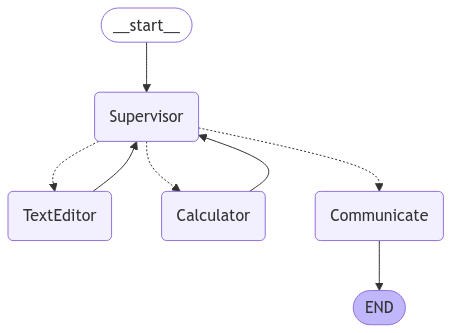

In [61]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import time
from google.oauth2 import service_account
from langchain_google_vertexai import ChatVertexAI
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate
from langchain.schema import HumanMessage, BaseMessage
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph
from typing_extensions import Annotated, TypedDict
from typing import Sequence
from pydantic import BaseModel
import operator
import functools
from enum import Enum

# === 1. Setup Vertex AI with credentials ===
credentials_path = "E:/LLM_clone/Tdtu-chatbot/credentials/tdtuchat-16614553b756.json"
credentials = service_account.Credentials.from_service_account_file(credentials_path)

llm = ChatVertexAI(
    model="gemini-1.5-pro",
    temperature=0.6,
    max_tokens=200,
    credentials=credentials,
    max_retries=5
)

# === 2. Retry mechanism with fixed delay ===
def retry_with_fixed_delay(func, max_retries=5, delay=4):
    """
    Retry a function with a fixed delay if it raises an exception.
    """
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            print(f"Error: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)

# === 3. Define tools for operations ===
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

@tool
def square(a: int) -> int:
    """Calculate the square of a number."""
    return a * a

@tool
def make_upper_case(text: str) -> str:
    """Convert the input text to uppercase."""
    return text.upper()

@tool
def make_lower_case(text: str) -> str:
    """Convert the input text to lowercase."""
    return text.lower()

@tool
def add_smiley(text: str) -> str:
    """Add a smiley face to the end of the input text."""
    return text + " :)"

math_toolkit = [add, multiply, square]
text_toolkit = [make_upper_case, make_lower_case, add_smiley]

# === 4. Helper function to create tool agents ===
def create_tool_agent(llm, tools, system_prompt):
    """
    Create an agent executor with tools and system prompt.
    """
    system_prompt_template = PromptTemplate(
        template=system_prompt + """
            ONLY respond to the part of query relevant to your purpose.
            IGNORE tasks you can't complete.
            Use the following context to answer your query:
            {agent_history}
        """,
        input_variables=["agent_history"],
    )

    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

    prompt = ChatPromptTemplate.from_messages([
        system_message_prompt,
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    agent = create_tool_calling_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True, verbose=False)

# === 5. Create agents ===
math_agent = create_tool_agent(llm=llm, tools=math_toolkit, system_prompt="You are a mathematical assistant.")
text_agent = create_tool_agent(llm=llm, tools=text_toolkit, system_prompt="You are a text editor assistant.")

# === 6. Define comms_agent ===
comms_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate(
        prompt=PromptTemplate(
            template="You summarize agent history in response to the user query: {agent_history}",
            input_variables=["agent_history"]
        )
    ),
    MessagesPlaceholder(variable_name="messages"),
])

comms_agent = comms_prompt | llm

# === 7. Supervisor chain ===
members = ["Calculator", "TextEditor", "Communicate"]
MemberEnum = Enum('MemberEnum', {member: member for member in members})

class SupervisorOutput(BaseModel):
    next: MemberEnum

supervisor_parser = JsonOutputParser(pydantic_object=SupervisorOutput)

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """
        You are a supervisor managing a conversation between crew members: {members}.
        Select one of: {options}.
        Return your response as a JSON object with the following format:
        {{
            "next": "<selected_option>"
        }}
        {format_instructions}
    """),
    MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_history")
]).partial(
    options=str(members),
    members=", ".join(members),
    format_instructions=supervisor_parser.get_format_instructions()
)

supervisor_chain = supervisor_prompt | llm | supervisor_parser

# === 8. Workflow ===
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
    agent_history: Annotated[Sequence[BaseMessage], operator.add]

workflow = StateGraph(AgentState)

# def crew_nodes(state, crew_member, name):
#     def invoke():
#         input_data = {'messages': [state['messages'][-1]], 'agent_history': state['agent_history']}
#         result = crew_member.invoke(input_data)
#         return {"agent_history": [AIMessage(content=result["output"], additional_kwargs={'intermediate_steps': result['intermediate_steps']}, name=name)]}
#     return retry_with_fixed_delay(invoke)

# def comms_node(state):
#     def invoke():
#         input_data = {'messages': [state['messages'][-1]], 'agent_history': state['agent_history']}
#         result = comms_agent.invoke(input_data)
#         return {"messages": [result]}
#     return retry_with_fixed_delay(invoke)

# --------------------#
##New code
def crew_nodes(state, crew_member, name):
    def invoke():
        input_data = {
            "messages": state["messages"],
            "agent_history": state.get("agent_history", [])  # Đảm bảo agent_history có giá trị mặc định
        }
        result = crew_member.invoke(input_data)

        # Cập nhật đúng `AgentState`
        return {
            "messages": state["messages"],  # Giữ nguyên messages
            "agent_history": state["agent_history"] + [
                AIMessage(
                    content=result["output"],
                    additional_kwargs={"intermediate_steps": result["intermediate_steps"]},
                    name=name
                )
            ]
        }

    return retry_with_fixed_delay(invoke)

def comms_node(state):
    def invoke():
        input_data = {
            "messages": state["messages"],
            "agent_history": state.get("agent_history", [])
        }
        result = comms_agent.invoke(input_data)

        # Cập nhật `messages` trong `AgentState`
        return {
            "messages": state["messages"] + [result],  # Thêm tin nhắn mới
            "agent_history": state["agent_history"]  # Giữ nguyên agent_history
        }

    return retry_with_fixed_delay(invoke)



#--------
workflow.add_node("TextEditor", functools.partial(crew_nodes, crew_member=text_agent, name="TextEditor"))
workflow.add_node("Calculator", functools.partial(crew_nodes, crew_member=math_agent, name="Calculator"))
workflow.add_node("Communicate", comms_node)
workflow.add_node("Supervisor", supervisor_chain)
# workflow.add_node("END", lambda state: state)
workflow.add_node("END", lambda state: {
    "messages": state["messages"],  # Giữ nguyên messages
    "agent_history": state["agent_history"],  # Giữ nguyên agent_history
    "next": None  # Đặt next thành None để kết thúc
})


workflow.set_entry_point("Supervisor")

workflow.add_edge("TextEditor", "Supervisor")
workflow.add_edge("Calculator", "Supervisor")
workflow.add_edge("Communicate", "END")
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], {member: member for member in members})


def get_geminai_agent():
    """
    Tạo và trả về AgentExecutor dựa trên workflow.
    """
    # Tạo AgentExecutor bằng cách sử dụng Supervisor Chain
    def invoke(state):
        input_data = {
            "messages": state["messages"],
            "agent_history": state["agent_history"]
        }
        response = supervisor_chain.invoke(input_data)
        return response

    return AgentExecutor(agent=workflow.compile(), tools=[], return_intermediate_steps=False, verbose=True)


# # === 9. Execute graph with retry ===
# def execute_graph():
#     try:
#         for s in workflow.compile().stream(
#             {
#                 "messages": [
#                     HumanMessage(content="Hi! can you make the following text all upper case: 'banana' and tell me what 2*2 is?")
#                 ]
#             }
#         ):
#             if "__end__" not in s:
#                 print(s)
#                 print("----")
#     except Exception as e:
#         print(f"Execution failed: {e}")

# execute_graph()
